In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
 
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import pickle
import time
 
drive.mount('/content/gdrive')
PATH="/content/gdrive/MyDrive"
!ls /content/gdrive/MyDrive/DataSet
 
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
device="cuda:0"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
example2.pickle  M_16_1.pickle	 M_16_60.pickle  M_8_200.pickle
example.pickle	 M_16_30.pickle  M_8_10.pickle	 M_8_60.pickle
M_16_10.pickle	 M_16_3.pickle	 M_8_1.pickle
True
0
1
Tesla T4


In [ ]:
batch_size=100
num_epochs=10 # 앞선 CNN보다 5배까지 키울 수 있음 # 지금까지 약 40epochs
workers=2
D_iter=4 # G보다 D를 D_iter배 만큼 많이 훈련시킴
traditional_loss=20 #Generator의 update에서 Discriminator의 loss에 대한 traditional loss의 반영 비율
lr_G=0.0005
lr_D=0.005
beta1=0.5
n=16
im_sz=n+2
im_sq=im_sz*im_sz
#log_interval=100
log_interval=100 # light한 데이터로 테스트 할 경우에만
INF=100000

In [ ]:
class M_Dataset(Dataset):
  def __init__(self,path,name,transform=None):
    with open(path+name+'.pickle', 'rb') as f:
      self.data_all = pickle.load(f)
    self.transform=transform

  def __len__(self):
    return len(self.data_all)

  def __getitem__(self,idx):
    sample=self.data_all[idx]
    data, target=torch.from_numpy(sample[0]), torch.from_numpy(sample[1])
    return data,target

In [ ]:
# BatchNorm 말고 Dropout쓰는 경우, 안 쓰는 경우 모두 실험해보자.
# 기본적으로 noise를 추가하는 게 정석이지만, deep convolution 연산에 영향을 줄 수 있을 것 같아서 일단 뺐다.\
class Net_G(nn.Module):
  def __init__(self):
    super(Net_G, self).__init__()
    self.main=nn.Sequential(
      # Expand feature
      nn.ConvTranspose2d(1,150,5,1),
      nn.BatchNorm2d(150),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(150,200,5,1),
      nn.BatchNorm2d(200),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(200,400,5,1),
      nn.BatchNorm2d(400),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(400,600,5,1),
      nn.BatchNorm2d(600),
      nn.ReLU(inplace=True),
      # Retract feature
      nn.Conv2d(600,400,5,1),
      nn.BatchNorm2d(400),
      nn.ReLU(inplace=True),
      nn.Conv2d(400,200,5,1),
      nn.BatchNorm2d(200),
      nn.ReLU(inplace=True),
      nn.Conv2d(200,150,5,1),
      nn.BatchNorm2d(150),
      nn.ReLU(inplace=True),
      nn.Conv2d(150,1,5,1),
      nn.BatchNorm2d(1),
      # sigmoid
      nn.Sigmoid()
    )
  def forward(self,input):
    return self.main(input)
    # batch_size*1*18*18이겠죠


class D_WGAN(nn.Module):
  def __init__(self):
    super(D_WGAN, self).__init__()
    self.leaky=nn.LeakyReLU(0.2, inplace=True)
    self.conv1=nn.Conv2d(1,150,5,2,1)
    self.bn1=nn.BatchNorm2d(150)
    self.conv2=nn.Conv2d(150,200,4,2,1)
    self.bn2=nn.BatchNorm2d(200)
    self.conv3=nn.Conv2d(200,400,4,2,1)
    self.bn3=nn.BatchNorm2d(400)
    # batch*400*2*2
    self.fc1=nn.Linear(2*400*2*2,1000)
    self.fc2=nn.Linear(1000,1)
    self.bn4=nn.BatchNorm1d(1000)

  def forward(self,x,label):
    x=self.conv1(x)
    x=self.bn1(x)
    x=self.leaky(x)
    x=self.conv2(x)
    x=self.bn2(x)
    x=self.leaky(x)
    x=self.conv3(x)
    x=self.bn3(x)

    y=self.conv1(label)
    y=self.bn1(y)
    y=self.leaky(y)
    y=self.conv2(y)
    y=self.bn2(y)
    y=self.leaky(y)
    y=self.conv3(y)
    y=self.bn3(y)
    # batch*600*4*4
    
    x=x.view(batch_size,-1)
    y=y.view(batch_size,-1)
    x=torch.cat([x,y],dim=1)

    x=self.fc1(x)
    x=self.bn4(x)
    x=F.relu(x)
    x=self.fc2(x)

    x=x.view(-1)
    # 아니 어떻게 nn.sigmoid(x)를 아직도 안바
    return x
    # batch


In [ ]:
def param_save(NetG,NetD,optimG,optimD,path,name,epoch=0,lossG=0,lossD=0):
  state_dict={'NetG_state_dict':NetG.state_dict(),\
              'NetD_state_dict':NetD.state_dict(),\
              'optimG_state_dict':optimG.state_dict(),\
              'optimD_state_dict':optimD.state_dict(),\
              'epoch':epoch,\
              'lossG':lossG,\
              'lossD':lossD,\
              }
  torch.save(state_dict,path+name)

def param_load(NetG,NetD,optimG,optimD,path,name):
  checkpoint = torch.load(path+name)
  NetG.load_state_dict(checkpoint['NetG_state_dict'])
  NetD.load_state_dict(checkpoint['NetD_state_dict'])
  optimG.load_state_dict(checkpoint['optimG_state_dict'])
  optimD.load_state_dict(checkpoint['optimD_state_dict'])
  epoch = checkpoint['epoch']
  lossG = checkpoint['lossG']
  lossD = checkpoint['lossD']
  return epoch,lossG,lossD

In [ ]:
def correct(path, output):
  # -1 차원 벡터만 받는다.
  result=0
  flag=True
  for i in range(len(path)):
    if abs(path[i]-output[i])>0.5:
      flag=False
      break
  if flag:
    result=1
  return result

In [ ]:
def train(NetG,NetD,optimG,optimD,criterion,train_loader,device,epoch,t0,\
          loss_list_G,loss_list_D,loss_list_T,D_fake,D_real,log_interval=100):
  NetG.train()
  NetD.train()
  real_label=1.
  fake_label=0.

  for batch_idx,tensor in enumerate(train_loader,0):
    data,target=tensor[0].to(device),tensor[1].to(device)
    data,target=data.type(torch.float),target.type(torch.float)

    if batch_idx%(D_iter+1)!=D_iter:
      # train D
      NetD.zero_grad()
      data,target=data.unsqueeze(dim=1),target.unsqueeze(dim=1) # CNN을 위한 channel추가
      output_real=NetD(data,target)

      fake_path=NetG(data) # 나중에 noise추가
      output_fake=NetD(data,fake_path)
      errD=-torch.mean(output_real-output_fake)
      errD.backward()
      optimD.step()

      if batch_idx%(D_iter+1)==D_iter-1:
        D_real.append(output_real.mean().item())
        D_fake.append(output_fake.mean().item())
        loss_list_D.append(errD.item())

      for p in NetD.parameters():
        p.data.clamp_(-0.01,0.01) #0.01에서 바꿈


    else:
      # train G
      NetG.zero_grad()
      data=data.unsqueeze(dim=1) # CNN을 위한 channel추가
      fake_path=NetG(data) # 나중에 noise추가
      output=NetD(data,fake_path)
      errG=-torch.mean(output)

      fake_path,target=fake_path.view(batch_size,-1),target.view(batch_size,-1)
      BCEloss=criterion(fake_path,target)

      Gloss=errG+BCEloss*traditional_loss
      Gloss.backward()
      optimG.step()
      loss_list_G.append(errG.item())
      loss_list_T.append(BCEloss.item())

    if batch_idx % log_interval==log_interval-1:
      print("Train epoch :",epoch,"[",(batch_idx+1)*len(data),"/",len(train_loader.dataset),"]"\
            ", Time : ",time.time()-t0)
      print("BCEloss :",loss_list_T[-1],", errD :",loss_list_D[-1],", errG :",loss_list_G[-1],\
            ", D_real :",D_real[-1],", D_fake :",D_fake[-1])

 
def test(NetG,criterion,test_loader,device,loss_list): # NetD는 굳이 필요가 없다.
  NetG.eval()
  test_loss=0
  acc=0
  with torch.no_grad():
    for tensor in test_loader:
      data,target=tensor[0].to(device),tensor[1].to(device)
      data,target=data.type(torch.float),target.type(torch.float)
      data=data.unsqueeze(dim=1)
      output=NetG(data) # 나중에 noise추가
      output,target=output.view(batch_size,-1),target.view(batch_size,-1)
      loss=criterion(output,target)
      test_loss+=loss.item()
    
    test_loss/=len(test_loader.dataset)/batch_size
    loss_list.append(test_loss)
    print("Test Time Average BCE_loss :",test_loss)
    return test_loss

In [ ]:
PATH_D=PATH+"/DataSet"
PATH_M=PATH+"/Model"
name="/M_16_60"
#name="/M_16_10"
dataset=M_Dataset(PATH_D,name)
dataloader=DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
t_name="/M_16_10"
#t_name="/M_16_3"
t_dataset=M_Dataset(PATH_D,t_name)
t_dataloader=DataLoader(t_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
 
criterion=torch.nn.BCELoss()
NetG=Net_G().to(device)
NetD=D_WGAN().to(device)
optimG=optim.Adam(NetG.parameters(), lr=lr_G, betas=(beta1, 0.999))
optimD=optim.Adam(NetD.parameters(), lr=lr_D, betas=(beta1, 0.999))
 
#print(NetG)
#print(NetD)
 
loss_list_G=[] # errG
loss_list_D=[] # errD
loss_list_T=[] # BCE loss
D_fake=[] # Discriminator value (fake)
D_real=[] # Discriminator value (real)
Test_loss=[] # Test time BCE loss
t0=time.time()

last_loss=INF
'''
#=======================추가학습===========================
param_load(NetG,NetD,optimG,optimD,PATH_M,"/WGAN_Pure.pt")
#==========================================================

for epoch in range(1,num_epochs+1):
  train(NetG,NetD,optimG,optimD,criterion,dataloader,device,epoch,t0,\
        loss_list_G,loss_list_D,loss_list_T,D_fake,D_real,log_interval)
  curr_loss=test(NetG,criterion,t_dataloader,device,Test_loss)
  if curr_loss<last_loss:
    last_loss=curr_loss
    param_save(NetG,NetD,optimG,optimD,PATH_M,"/WGAN_Pure.pt")
 '''
# Previous Result Board
# BCEloss가 0.22까지 내려감
# 그래도 SOTA에 도달하려면 10배는 더 줄여야 함
# Average loss : 0.18569431909173728  Accuracy : 0.071
# Suggested Model - Average loss : 0.402892170727253  Accuracy : 0.101
# All-MSEloss Model - Average loss : 0.38129404601454736  Accuracy : 0.039
# Average loss : 0.24918328493336836  Accuracy : 0.741
# 30 epochs Average loss : 0.032061763702581327  Accuracy : 0.9576666666666667
# 40 epochs Average loss : 0.0228432459620138  Accuracy : 0.964
# 50 epochs Average loss : 0.015712913215781252  Accuracy : 0.9796666666666667


'\n#=======================추가학습===========================\nparam_load(NetG,NetD,optimG,optimD,PATH_M,"/WGAN_Pure.pt")\n#==========================================================\n\nfor epoch in range(1,num_epochs+1):\n  train(NetG,NetD,optimG,optimD,criterion,dataloader,device,epoch,t0,        loss_list_G,loss_list_D,loss_list_T,D_fake,D_real,log_interval)\n  curr_loss=test(NetG,criterion,t_dataloader,device,Test_loss)\n  if curr_loss<last_loss:\n    last_loss=curr_loss\n    param_save(NetG,NetD,optimG,optimD,PATH_M,"/WGAN_Pure.pt")\n '

In [ ]:

param_load(NetG,NetD,optimG,optimD,PATH_M,"/WGAN_Pure_0.9913.pt")
'''
fig=plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.plot(loss_list_G,label="loss_G")
plt.plot(loss_list_D,label="loss_D")
plt.plot(loss_list_T,label="BCE_loss")
plt.legend()


plt.subplot(3,1,2)
plt.plot(D_fake,label="D_fake")
plt.plot(D_real,label="D_real")
plt.legend()

plt.subplot(3,1,3)
plt.plot([(len(dataloader)/log_interval)*x+len(dataloader)/batch_size/log_interval-1 for x in range(num_epochs)],Test_loss,\
         label="Test BCEloss")
plt.legend()
plt.show()
'''

'\nfig=plt.figure(figsize=(8,12))\nplt.subplot(3,1,1)\nplt.plot(loss_list_G,label="loss_G")\nplt.plot(loss_list_D,label="loss_D")\nplt.plot(loss_list_T,label="BCE_loss")\nplt.legend()\n\n\nplt.subplot(3,1,2)\nplt.plot(D_fake,label="D_fake")\nplt.plot(D_real,label="D_real")\nplt.legend()\n\nplt.subplot(3,1,3)\nplt.plot([(len(dataloader)/log_interval)*x+len(dataloader)/batch_size/log_interval-1 for x in range(num_epochs)],Test_loss,         label="Test BCEloss")\nplt.legend()\nplt.show()\n'

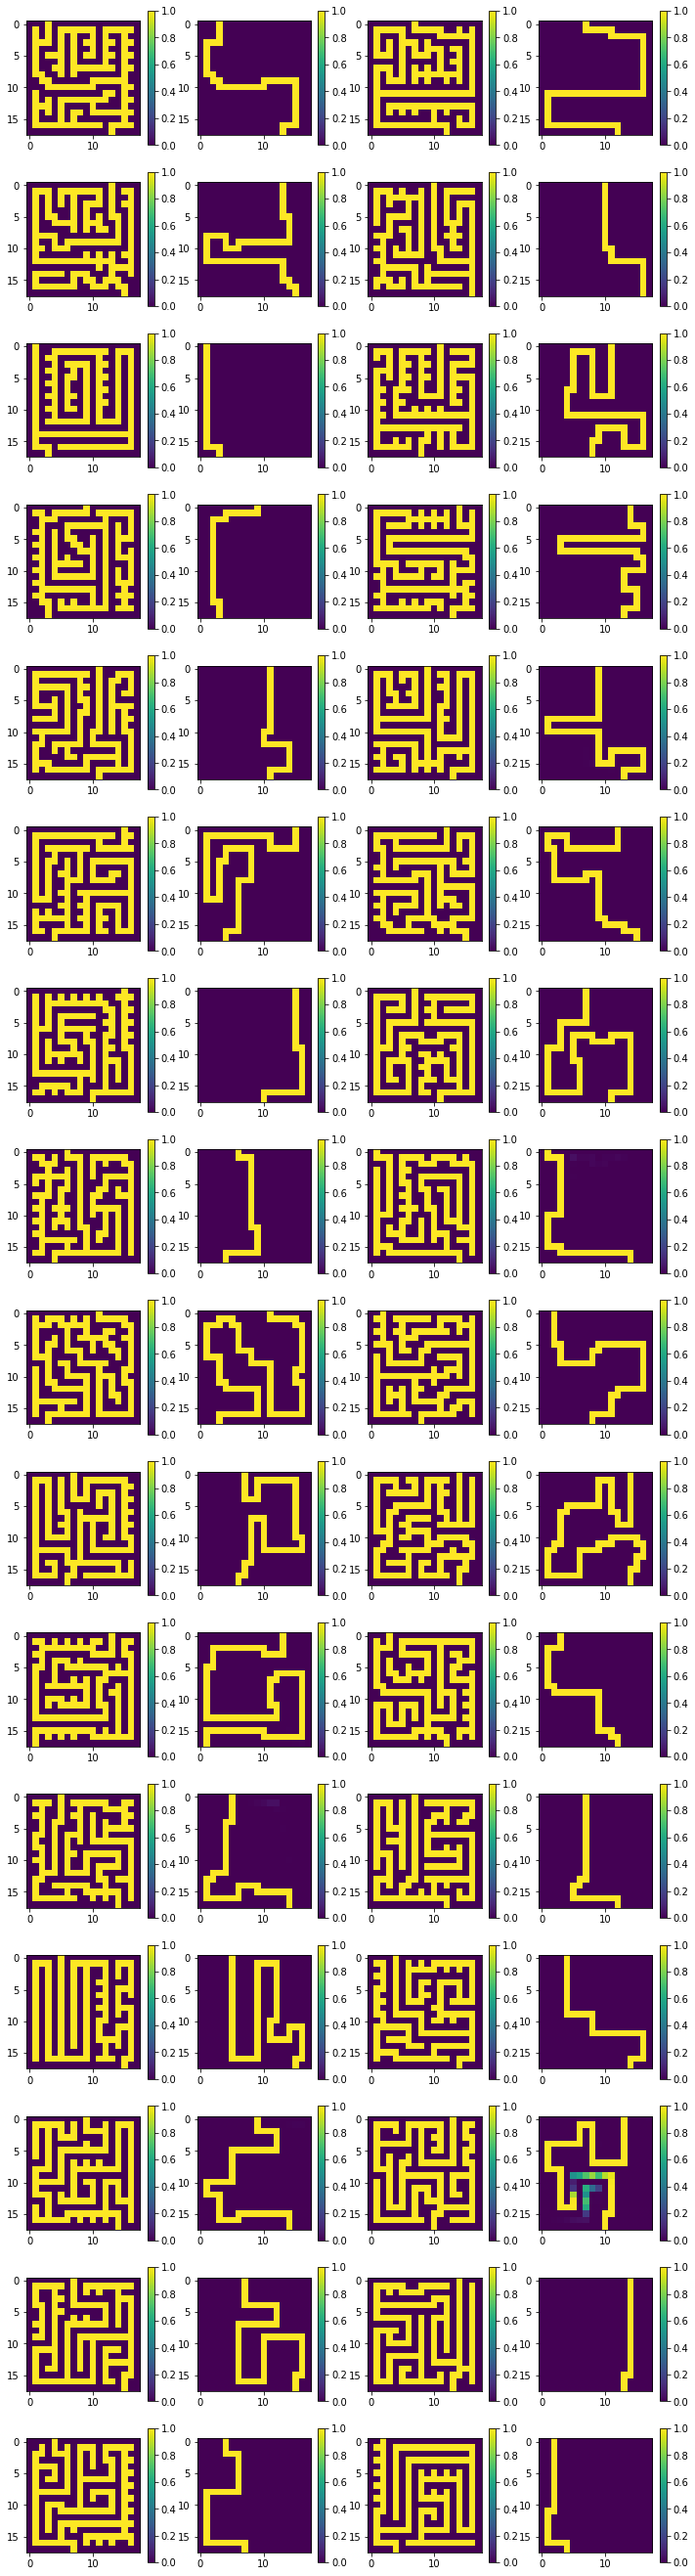

In [ ]:
tensor=next(iter(t_dataloader))
data,target=tensor[0].to(device),tensor[1].to(device)
data,target=data.type(torch.float),target.type(torch.float)
data=data.unsqueeze(dim=1)
output=NetG(data)
output=output.detach()

fig=plt.figure(figsize=(12,48))
for m in range(32):
  plt.subplot(16,4,2*m+1)
  plt.imshow(tensor[0][m])
  plt.colorbar()
  path=torch.reshape(output[m],(im_sz,im_sz))
  plt.subplot(16,4,2*m+2)
  plt.colorbar()
  plt.imshow(path.cpu().numpy())

In [ ]:
dir=[[-1,0],[0,1],[1,0],[0,-1]]

def DFS_atr(table,path,visited,N,pos,dir_idx,end_x,turn_cnt,branch_cnt,length):
  if visited[pos[0]][pos[1]]:
    return False
  visited[pos[0]][pos[1]]=True
  length[0]+=1
  if pos!=[N-1,end_x]:
    flag=False
    for i in range(4):
      a_n=pos[0]+dir[i][0]
      b_n=pos[1]+dir[i][1]
      if (0<=a_n<N and 0<=b_n<N):
        if (path[a_n][b_n] and i!=((dir_idx+2)%4)):
          flag=True
          dir_temp=i
          a_f=a_n
          b_f=b_n
        if (not path[a_n][b_n]) and table[a_n][b_n]:
          branch_cnt[0]+=1
    if flag:
      if dir_temp!=dir_idx:
        turn_cnt[0]+=1
      DFS_atr(table,path,visited,N,[a_f,b_f],dir_temp,end_x,turn_cnt,branch_cnt,length)

def get_attribute(table,path):
  # turn_cnt, branch_cnt, length를 구해보자.
  N=len(table)
  for i in range(N):
    if path[0][i]:
      start_x=i
    if path[N-1][i]:
      end_x=i
  turn_cnt=[0]
  branch_cnt=[0]
  length=[0]
  visited=[[False for i in range(N)] for j in range(N)]
  DFS_atr(table,path,visited,N,[0,start_x],2,end_x,turn_cnt,branch_cnt,length)
  return turn_cnt[0], branch_cnt[0], length[0]

Average loss : 0.006131044701673091  Accuracy : 0.991
Time : 70.75361442565918


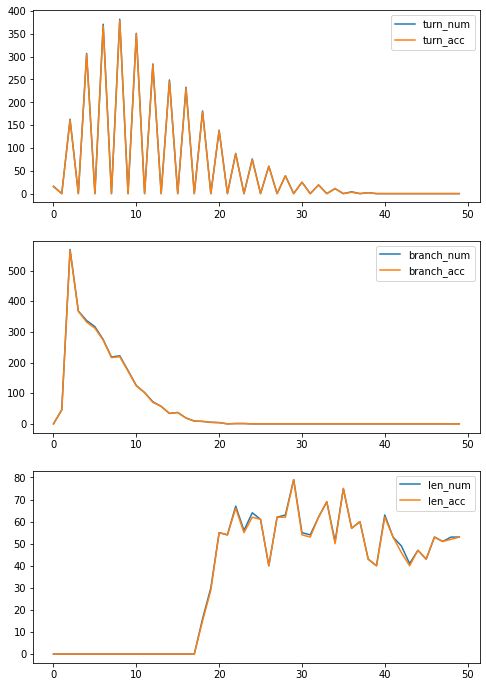

In [ ]:
with open(PATH_D+"/M_16_3"+'.pickle', 'rb') as f:
  #with open(PATH_D+"/M_16_1"+'.pickle', 'rb') as f:
  data_temp = pickle.load(f)
NetG.eval()
test_loss=0
acc=0
u_bound=50
turn_num=[0 for i in range(u_bound)]
branch_num=[0 for i in range(u_bound)]
length_num=[0 for i in range(u_bound)]
turn_cnt=[0 for i in range(u_bound)]
branch_cnt=[0 for i in range(u_bound)]
length=[0 for i in range(u_bound)]
t3=time.time()

wrong_list=[]

with torch.no_grad():
  for idx,sample in enumerate(data_temp):
    t,b,l=get_attribute(sample[0],sample[1])
    data,target=torch.from_numpy(sample[0]), torch.from_numpy(sample[1])
    data,target=data.to(device),target.to(device)
    data,target=data.type(torch.float),target.type(torch.float)
    target=target.view(-1)
    data=data.view(1,1,im_sz,im_sz)
    output=NetG(data)
    output=output.view(-1)
    loss=criterion(output,target)
    acc_temp=correct(output,target)
    if t<u_bound:
      turn_num[t]+=1
    if b<u_bound:
      branch_num[b]+=1
    if l<u_bound:
      length_num[l]+=1
    if (acc_temp==1):
      if t<u_bound:
        turn_cnt[t]+=1
      if b<u_bound:
        branch_cnt[b]+=1
      if l<u_bound:
        length[l]+=1
    acc+=acc_temp
    test_loss+=loss.item()
    
    if (acc_temp==0):
      wrong_list.append(idx)

  test_loss/=len(data_temp)
  acc/=len(data_temp)
  print("Average loss :",test_loss," Accuracy :",acc)
  print("Time :",time.time()-t3)
  fig=plt.figure(figsize=(8,12))
  plt.subplot(3,1,1)
  plt.plot(turn_num,label='turn_num')
  plt.plot(turn_cnt,label='turn_acc')
  plt.legend()
  plt.subplot(3,1,2)
  plt.plot(branch_num,label='branch_num')
  plt.plot(branch_cnt,label='branch_acc')
  plt.legend()
  plt.subplot(3,1,3)
  plt.plot(length_num,label='len_num')
  plt.plot(length,label='len_acc')
  plt.legend()
  plt.show()
  

  # 여기서 얻은 교훈. 반복되는 연산을 줄이는 코드를 짜는데 필요한 시간을 걱정하지 마라.

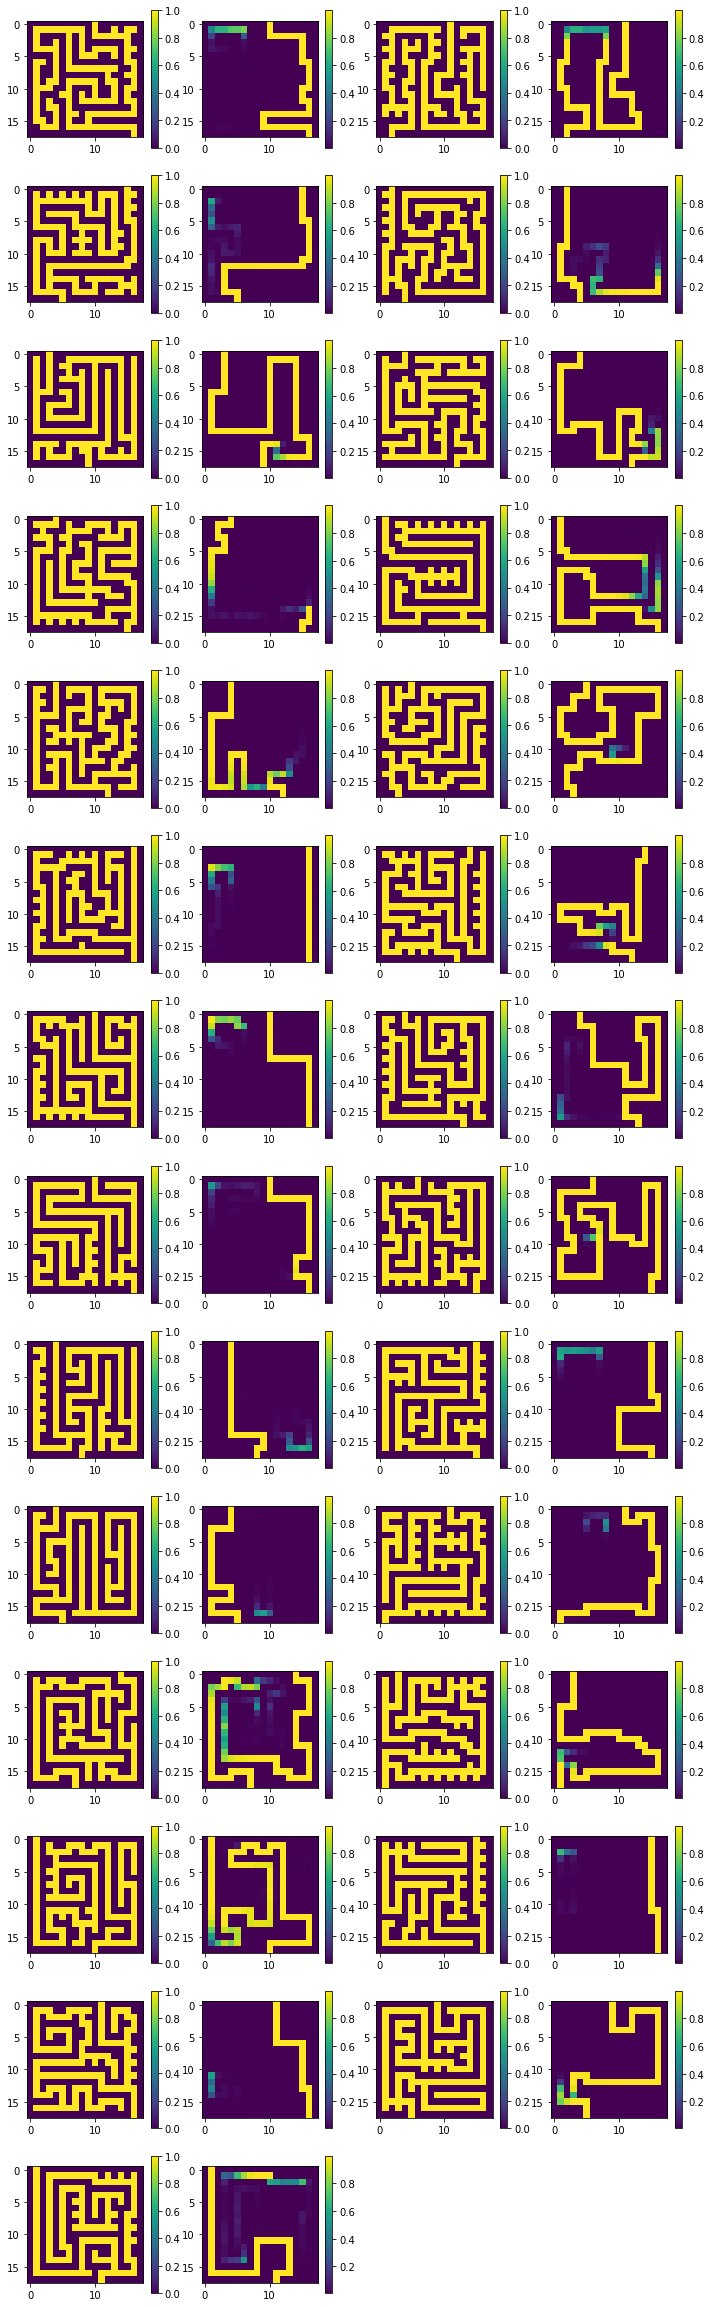

In [ ]:
# 틀린부분 모델링
fig=plt.figure(figsize=(12,3*((len(wrong_list)+1)//2)))

for i,idx in enumerate(wrong_list):
  sample=data_temp[idx]
  data=torch.from_numpy(sample[0])
  data=data.to(device)
  data=data.type(torch.float)
  data=data.view(1,1,im_sz,im_sz)
  output=NetG(data)
  data,output=data.detach(),output.detach()

  plt.subplot((len(wrong_list)+1)//2,4,2*i+1)
  data=torch.reshape(data,(im_sz,im_sz))
  plt.imshow(data.cpu().numpy())
  plt.colorbar()
  plt.subplot((len(wrong_list)+1)//2,4,2*i+2)
  output=torch.reshape(output,(im_sz,im_sz))
  plt.imshow(output.cpu().numpy())
  plt.colorbar()